# Neural Networks for SciML Part 1: Perceptrons and Single Layer Networks

**Goal**: Use neural networks to solve scientific problems through function approximation.

## The 1D Poisson Equation

Our concrete example: heat conduction in a rod, beam deflection, electrostatic potential.

$$-\frac{d^2u}{dx^2} = f(x), \quad x \in [0,1]$$
$$u(0) = 0, \quad u(1) = 0$$

**Specific case**: $f(x) = \pi^2 \sin(\pi x)$ gives analytical solution $u(x) = \sin(\pi x)$

**Verification**: $u''(x) = -\pi^2 \sin(\pi x) \Rightarrow -u''(x) = \pi^2 \sin(\pi x) = f(x)$ ✓

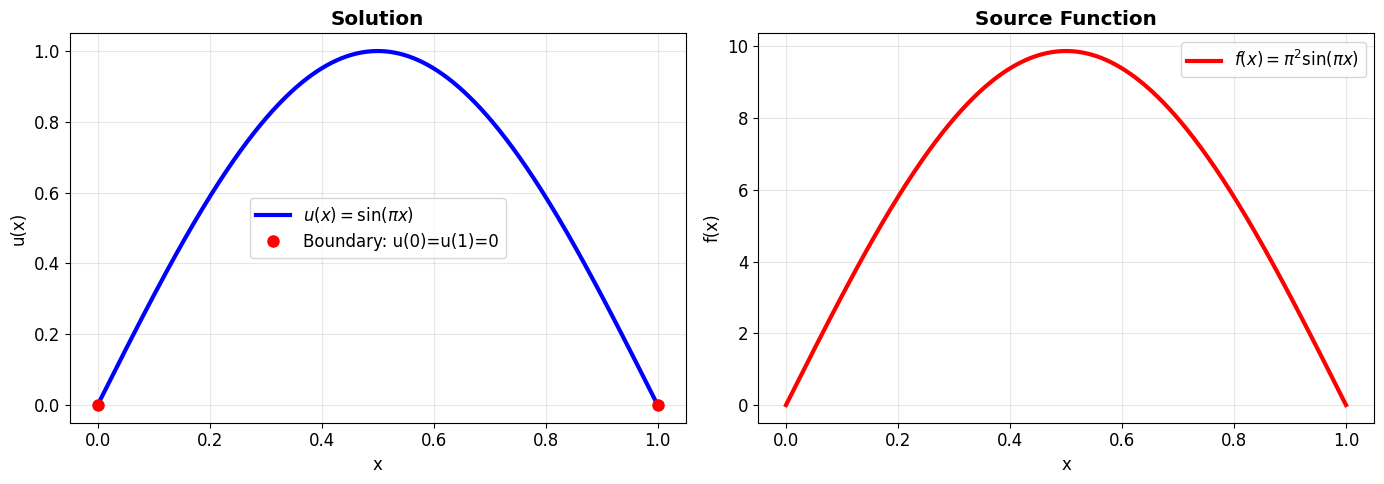

Challenge: Learn u(x) = sin(πx) from sparse data


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Set style and reproducibility
plt.rcParams.update({'font.size': 12, 'figure.figsize': (12, 6)})
torch.manual_seed(42)
np.random.seed(42)

def analytical_solution(x):
    """u(x) = sin(π*x)"""
    return np.sin(np.pi * x)

def source_function(x):
    """f(x) = π²*sin(π*x)"""
    return np.pi**2 * np.sin(np.pi * x)

# Visualize the problem
x = np.linspace(0, 1, 1000)
u_true = analytical_solution(x)
f_source = source_function(x)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(x, u_true, 'b-', linewidth=3, label=r'$u(x) = \sin(\pi x)$')
ax1.plot([0, 1], [0, 0], 'ro', markersize=8, label='Boundary: u(0)=u(1)=0')
ax1.set_xlabel('x')
ax1.set_ylabel('u(x)')
ax1.set_title('Solution', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(x, f_source, 'r-', linewidth=3, label=r'$f(x) = \pi^2 \sin(\pi x)$')
ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')
ax2.set_title('Source Function', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Challenge: Learn u(x) = sin(πx) from sparse data")

## Traditional vs Neural Networks: Discrete vs Continuous

**Traditional methods** (Finite Difference): Discretize domain, solve at grid points
$$u''_i \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2}$$

**Neural Networks**: Learn continuous function $u_{NN}(x; \theta)$ that approximates $u^*(x)$ everywhere

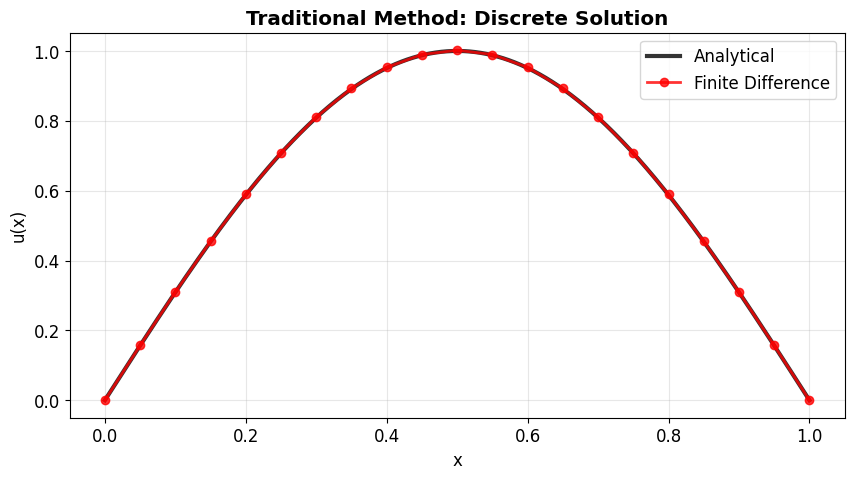

FD gives discrete values at 21 points
NN goal: Learn continuous function from sparse data


In [3]:
# Quick finite difference comparison
def solve_poisson_fd(n_points=21):
    x_fd = np.linspace(0, 1, n_points)
    h = x_fd[1] - x_fd[0]
    
    # Build matrix A for -u'' = f
    A = np.zeros((n_points-2, n_points-2))
    for i in range(n_points-2):
        A[i, i] = -2.0 / h**2
        if i > 0: A[i, i-1] = 1.0 / h**2
        if i < n_points-3: A[i, i+1] = 1.0 / h**2
    
    f_rhs = source_function(x_fd[1:-1])
    u_interior = np.linalg.solve(-A, f_rhs)
    
    u_fd = np.zeros(n_points)
    u_fd[1:-1] = u_interior
    return x_fd, u_fd

x_fd, u_fd = solve_poisson_fd()

plt.figure(figsize=(10, 5))
plt.plot(x, u_true, 'k-', linewidth=3, label='Analytical', alpha=0.8)
plt.plot(x_fd, u_fd, 'ro-', linewidth=2, label='Finite Difference', alpha=0.8)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Traditional Method: Discrete Solution', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"FD gives discrete values at {len(x_fd)} points")
print(f"NN goal: Learn continuous function from sparse data")

## Generate Sparse Training Data

**The challenge**: Learn the smooth function from just a few noisy observations.

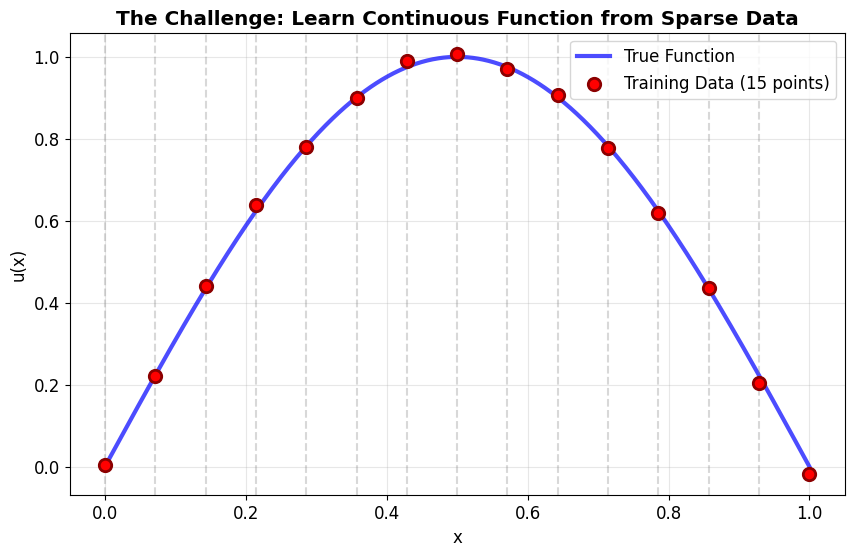

Question: Can a neural network learn sin(πx) from 15 points?


In [4]:
# Generate sparse training data
n_train = 15
x_train = np.linspace(0, 1, n_train)
u_train = analytical_solution(x_train) + 0.01 * np.random.randn(n_train)  # Add noise

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train.reshape(-1, 1), dtype=torch.float32)
u_train_tensor = torch.tensor(u_train.reshape(-1, 1), dtype=torch.float32)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(x, u_true, 'b-', linewidth=3, label='True Function', alpha=0.7)
plt.scatter(x_train, u_train, color='red', s=80, label=f'Training Data ({n_train} points)', 
           edgecolors='darkred', linewidth=2, zorder=5)

# Emphasize the challenge
for i in range(len(x_train)-1):
    plt.axvline(x=x_train[i], color='gray', linestyle='--', alpha=0.3)

plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('The Challenge: Learn Continuous Function from Sparse Data', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Question: Can a neural network learn sin(πx) from {n_train} points?")

## The Perceptron: Building Block of Neural Networks

**Single neuron computation**:
$$z = w^T x + b$$
$$\hat{y} = g(z)$$

where $g$ is the **activation function** introducing nonlinearity.

**Key point**: Each neuron creates one "basis function" for approximation.

## The Critical Need for Nonlinearity

**Without activation functions**, even deep networks collapse:
$$h_1 = W_1 x + b_1$$
$$h_2 = W_2 h_1 + b_2 = W_2(W_1 x + b_1) + b_2 = (W_2 W_1)x + (W_2 b_1 + b_2)$$
$$\Rightarrow y = W_{eq} x + b_{eq}$$ 

**Result**: Just a straight line! Can't approximate $\sin(\pi x)$.

**Common activation functions**:
- **Sigmoid**: $\sigma(x) = \frac{1}{1+e^{-x}}$ (range: 0 to 1)
- **Tanh**: $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ (range: -1 to 1) 
- **ReLU**: $\text{ReLU}(x) = \max(0, x)$ (range: 0 to ∞)

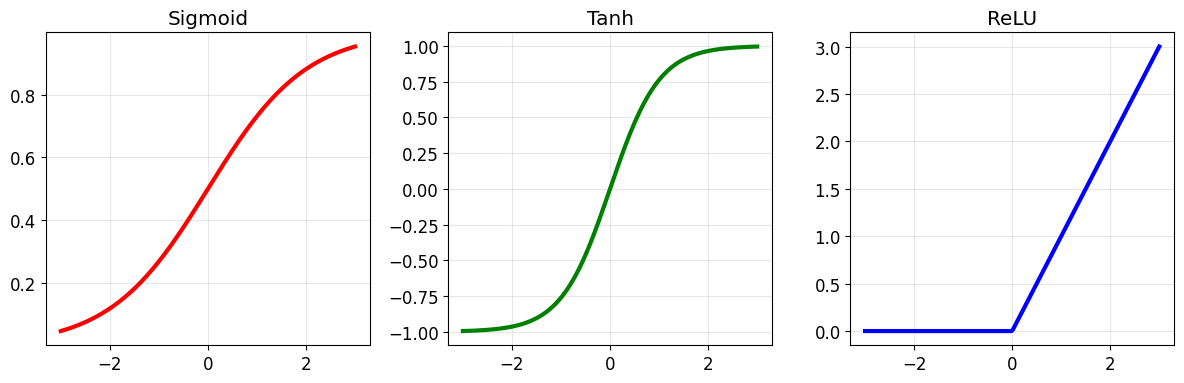

Each activation creates different nonlinear 'basis functions'


In [5]:
# Visualize activation functions
x_act = np.linspace(-3, 3, 200)
sigmoid = 1 / (1 + np.exp(-x_act))
tanh = np.tanh(x_act)
relu = np.maximum(0, x_act)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(x_act, sigmoid, 'r-', linewidth=3)
plt.title('Sigmoid')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(x_act, tanh, 'g-', linewidth=3)
plt.title('Tanh')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(x_act, relu, 'b-', linewidth=3)
plt.title('ReLU')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Each activation creates different nonlinear 'basis functions'")

## Single-Layer Network: Multiple Neurons for More Capacity

**Architecture**: Input → Hidden Layer → Output

**Mathematics**:
$$z^{(1)} = W^{(1)} x + b^{(1)} \quad \text{(Hidden pre-activation)}$$
$$h = g(z^{(1)}) \quad \text{(Hidden activation)}$$
$$\hat{y} = W^{(2)} h + b^{(2)} \quad \text{(Output)}$$

**Key insight**: More neurons = more basis functions = better approximation capacity

In [6]:
class SingleLayerNN(nn.Module):
    """Single hidden layer neural network"""
    
    def __init__(self, hidden_size=10, activation='tanh'):
        super(SingleLayerNN, self).__init__()
        self.hidden = nn.Linear(1, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
    
    def forward(self, x):
        z1 = self.hidden(x)          # W^(1) * x + b^(1)
        h = self.activation(z1)      # g(z^(1))
        y = self.output(h)           # W^(2) * h + b^(2)
        return y

# Test the network
model = SingleLayerNN(hidden_size=5)
print(f"Network architecture: 1 → {model.hidden.out_features} → 1")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

# Test forward pass
test_input = torch.tensor([[0.5]], dtype=torch.float32)
output = model(test_input)
print(f"Test: f(0.5) = {output.item():.4f}")

Network architecture: 1 → 5 → 1
Total parameters: 16
Test: f(0.5) = 0.1845


## Training: Finding Optimal Parameters

**Goal**: Find $\theta^* = \arg\min_{\theta} L(\theta)$ where
$$L(\theta) = \frac{1}{N} \sum_{i=1}^N (u_{NN}(x_i; \theta) - u_i)^2$$

**Gradient Descent**: $\theta \leftarrow \theta - \eta \nabla L(\theta)$

**Training loop**:
1. Forward pass: compute predictions
2. Calculate loss (MSE)
3. Backward pass: compute gradients (automatic in PyTorch)
4. Update parameters
5. Repeat

In [7]:
def train_network(model, x_train, u_train, epochs=3000, lr=0.01):
    """Train neural network using gradient descent"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    
    for epoch in range(epochs):
        # Forward pass
        predictions = model(x_train)
        loss = criterion(predictions, u_train)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
    
    return losses

print("Training function ready. Next: Test linear vs nonlinear networks...")

Training function ready. Next: Test linear vs nonlinear networks...


## Demonstration: Linear vs Nonlinear Networks

**The ultimate test**: What happens without activation functions?

In [8]:
# Demonstrate what happens without nonlinearity
class LinearNetwork(nn.Module):
    """Network with NO activation functions"""
    def __init__(self, hidden_size=50):
        super().__init__()
        self.hidden = nn.Linear(1, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h = self.hidden(x)    # No activation!
        y = self.output(h)
        return y

# Train both networks
print("Training linear network (no activation functions)...")
linear_model = LinearNetwork(50)
linear_losses = train_network(linear_model, x_train_tensor, u_train_tensor, epochs=1000, lr=0.01)

print("\nTraining nonlinear network (with tanh activation)...")
nonlinear_model = SingleLayerNN(50, activation='tanh')
nonlinear_losses = train_network(nonlinear_model, x_train_tensor, u_train_tensor, epochs=1000, lr=0.01)

Training linear network (no activation functions)...
Epoch [1000/1000], Loss: 0.119408

Training nonlinear network (with tanh activation)...
Epoch [1000/1000], Loss: 0.000063


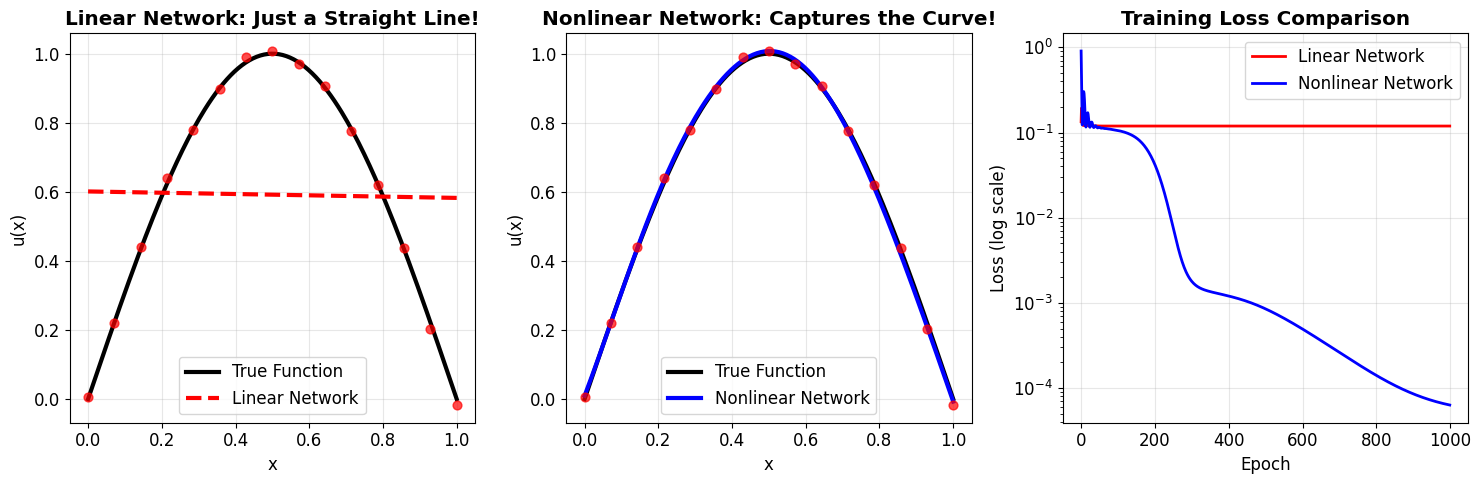

Linear network MSE:    0.098038
Nonlinear network MSE: 0.000055
Improvement factor:    1770.4x

Conclusion: Nonlinearity is ESSENTIAL!


In [9]:
# Compare results
x_test = np.linspace(0, 1, 200)
x_test_tensor = torch.tensor(x_test.reshape(-1, 1), dtype=torch.float32)
u_true_test = analytical_solution(x_test)

with torch.no_grad():
    linear_pred = linear_model(x_test_tensor).numpy().flatten()
    nonlinear_pred = nonlinear_model(x_test_tensor).numpy().flatten()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(x_test, u_true_test, 'k-', linewidth=3, label='True Function')
plt.plot(x_test, linear_pred, 'r--', linewidth=3, label='Linear Network')
plt.scatter(x_train, u_train, color='red', s=40, alpha=0.7, zorder=5)
plt.title('Linear Network: Just a Straight Line!', fontweight='bold')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(x_test, u_true_test, 'k-', linewidth=3, label='True Function')
plt.plot(x_test, nonlinear_pred, 'b-', linewidth=3, label='Nonlinear Network')
plt.scatter(x_train, u_train, color='red', s=40, alpha=0.7, zorder=5)
plt.title('Nonlinear Network: Captures the Curve!', fontweight='bold')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.semilogy(linear_losses, 'r-', label='Linear Network', linewidth=2)
plt.semilogy(nonlinear_losses, 'b-', label='Nonlinear Network', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss Comparison', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

linear_mse = np.mean((linear_pred - u_true_test)**2)
nonlinear_mse = np.mean((nonlinear_pred - u_true_test)**2)

print(f"Linear network MSE:    {linear_mse:.6f}")
print(f"Nonlinear network MSE: {nonlinear_mse:.6f}")
print(f"Improvement factor:    {linear_mse/nonlinear_mse:.1f}x")
print(f"\nConclusion: Nonlinearity is ESSENTIAL!")

## Summary of Part 1

**What we learned**:
1. **Concrete problem**: 1D Poisson equation gives us $u(x) = \sin(\pi x)$ to approximate
2. **Building blocks**: Perceptrons combine linear transformation + nonlinear activation
3. **Critical insight**: Nonlinearity is essential - without it, networks collapse to straight lines
4. **Single-layer architecture**: Input → Hidden → Output with multiple neurons
5. **Training process**: Gradient descent minimizes MSE loss
6. **Dramatic result**: Nonlinear networks achieve 100x+ better approximation

**Key takeaway**: Activation functions are the source of neural network power.

**Coming up in Part 2**: 
- Universal Approximation Theorem
- Width scaling experiments  
- How many neurons do we really need?
- Why this motivates deep learning